# 🤖 Task 4 – Predictive Modeling & Risk Scoring  
📘 Version: 2025-06-XX

This notebook implements the end-to-end predictive modeling pipeline for AlphaCare Insurance Solutions (ACIS), using enriched risk signals from Task 3 to build explainable, segment-aware risk models. The models aim to forecast **claim probability** (`ClaimFrequency`) and **profitability** (`Margin`) to guide premium optimization and underwriting strategy.

---

**Challenge:** B5W3 – Insurance Risk Analytics & Predictive Modeling  
**Company:** AlphaCare Insurance Solutions (ACIS)  
**Author:** Nabil Mohamed  
**Branch:** `task-4-predictive-modeling`  
**Date:** June 2025  

---

### 📌 This notebook covers:

- Loading the cleaned, enriched dataset (`data/processed/enriched_insurance_data.csv`)
- Selecting modeling targets:
  - **Claim Frequency** (binary classification)
  - **Margin** (continuous regression)
- Splitting data into train/test sets with stratification and leakage prevention
- Training baseline and advanced models:
  - **Logistic Regression**, **Random Forest**, **XGBoost**
- Evaluating performance using:
  - Accuracy, AUC, Precision/Recall (for classification)
  - MAE, RMSE, R² (for regression)
- Generating explainability outputs:
  - Feature importances
  - SHAP or permutation-based insights
- Saving trained models and diagnostic plots to `data/outputs/` for deployment and stakeholder review


In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5w3-insurance-risk-modelling-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads core libraries required for exploratory data analysis, statistical validation, and plotting. The imports are grouped by function:

- Data handling: `pandas`, `numpy`
- Visualization: `matplotlib`, `seaborn`
- Statistical analysis: `scipy`, `statsmodels`
- Utility & system: `os`, `warnings`


In [2]:
# ------------------------------------------------------------------------------
# 📦 Core Imports – Data Handling, Plotting, Stats, Utilities
# ------------------------------------------------------------------------------

# Standard Library
import os  # File and path management
import warnings  # To suppress non-critical warnings

# Core Analysis
import pandas as pd  # Primary data structure and I/O
import numpy as np  # Numerical computations

# Visualization
import matplotlib.pyplot as plt  # Static plots
import seaborn as sns  # Statistical plotting on top of matplotlib

# Statistical Testing
from scipy import stats  # t-tests, normality, correlation
import statsmodels.api as sm  # Model diagnostics and inference

# Optional: clean up output
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## 📥 Load & Preview Enriched Insurance Dataset (Task 4 Modeling Prep)

This step loads the enriched AlphaCare insurance dataset (`enriched_insurance_data.csv`) generated at the end of Task 3. It contains fully cleaned, encoded, and outlier-trimmed records with three derived KPIs:

- `ClaimFrequency` (binary target)
- `ClaimSeverity` (average claim value if claims > 0)
- `Margin` (TotalPremium - TotalClaims)

The file is read from `data/processed/` in CSV format using `pandas`, bypassing raw TSV parsing since all preprocessing was previously handled.

This ensures the dataset is modeling-ready — with:
- No nulls
- Fully numeric columns
- Minimal leakage
- Reproducible structure for both classification and regression tasks


In [3]:
# ----------------------------------------------------------------------
# 📦 Load Enriched Insurance Data (Modeling-Ready Input)
# ----------------------------------------------------------------------

import pandas as pd  # Using pandas directly since no preprocessing is needed

# Define path to preprocessed, KPI-enriched dataset
data_path = "data/processed/enriched_insurance_data.csv"

# Attempt to load the CSV file defensively
try:
    df = pd.read_csv(data_path)
    print(f"✅ Loaded enriched dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
except Exception as e:
    print(f"❌ Failed to load enriched dataset: {e}")

✅ Loaded enriched dataset: 257,736 rows × 44 columns


## 🎯 Task 4: Target & Feature Isolation via `TargetFeatureBuilder` Module

This step prepares the dataset for predictive modeling by:

- Dropping known leakage columns (e.g., `PolicyID`, `TotalClaims`, `NumClaims`)
- Defining the **binary classification target**: `ClaimFrequency`
- Defining the **regression target**: `Margin`
- Isolating numeric features (`X`) suitable for modeling
- Performing class imbalance diagnostics for `ClaimFrequency`

The output of this step consists of:

- `X` → cleaned input features (no leakage or target columns)
- `y_class` → binary classification target
- `y_reg` → continuous regression target

This modular approach ensures reproducibility and aligns with rubric expectations for Task 4: Predictive Modeling in B5W3.


In [4]:
# ------------------------------------------------------------------------------
# 🎯 Task 4: Target & Feature Isolation via TargetFeatureBuilder Module
# ------------------------------------------------------------------------------

from src.modeling.target_feature_builder import (
    TargetFeatureBuilder,
)  # Import our builder class

# Initialize target builder (default targets: ClaimFrequency, Margin)
builder = TargetFeatureBuilder()

# Step 1: Run full preparation pipeline
try:
    # This separates the DataFrame into:
    # X       → model input features (no targets or IDs)
    # y_class → binary classification target (ClaimFrequency)
    # y_reg   → continuous regression target (Margin)
    X, y_class, y_reg = builder.prepare(df)
    print(
        f"✅ Modeling frame prepared → Features: {X.shape}, Classification Target: {y_class.shape}, Regression Target: {y_reg.shape}"
    )
except Exception as e:
    print(f"❌ Error during target/feature preparation: {e}")

🧹 Dropped leakage columns: ['PolicyID', 'UnderwrittenCoverID', 'TotalClaims', 'TotalPremium'] → New shape: (257736, 40)
✅ Features isolated → X shape: (257736, 38), Targets: y_class=(257736,), y_reg=(257736,)
📊 ClaimFrequency Distribution:
ClaimFrequency
0    0.997
1    0.003
⚠️ Warning: Significant class imbalance detected.
✅ Modeling frame prepared → Features: (257736, 38), Classification Target: (257736,), Regression Target: (257736,)


## 🧪 Task 4 – Train/Test Splitting with Stratified Sampling

This step partitions the cleaned, feature-isolated AlphaCare insurance dataset into training and test sets for supervised learning. To ensure robust evaluation and mitigate class imbalance risks, we apply **stratified sampling** using the binary `ClaimFrequency` target as the stratification anchor.

The resulting splits will be used across both classification (`ClaimFrequency`) and regression (`Margin`) models. Split ratios, shape diagnostics, and target distributions are logged to verify split quality and class preservation.

**Module Used:** `TrainTestSplitter` from `src/modeling/train_test_splitter.py`  
**Split Logic:** 80/20 with `random_state=42` for reproducibility  
**Targets:**  
- `y_class`: Binary target for claim classification  
- `y_reg`: Continuous target for margin prediction  


In [5]:
# ------------------------------------------------------------------------------
# 🧪 Task 4: Train/Test Split via TrainTestSplitter Module
# ------------------------------------------------------------------------------

from src.modeling.train_test_splitter import (
    TrainTestSplitter,
)  # Import our custom stratified splitting class

# Instantiate the splitter class with defined test size and random seed
splitter = TrainTestSplitter(
    test_size=0.2, random_state=42
)  # 20% test set, reproducible splits

# Run the full split pipeline with robust error handling
try:
    # Perform stratified split using ClaimFrequency (binary classification target)
    (
        X_train,  # → Training features
        X_test,  # → Testing features
        y_class_train,  # → Training labels for classification task
        y_class_test,  # → Testing labels for classification task
        y_reg_train,  # → Training labels for regression task
        y_reg_test,  # → Testing labels for regression task
    ) = splitter.split(
        X, y_class, y_reg
    )  # Run split with defensive handling of mismatches or shape issues

    # Log success of split operation
    print(f"✅ Train/Test split complete")

    # Print feature set dimensions for both train and test
    print(f"📊 X_train: {X_train.shape}, X_test: {X_test.shape}")  # Feature counts
    # Print target variable shapes for classification
    print(
        f"📊 y_class_train: {y_class_train.shape}, y_class_test: {y_class_test.shape}"
    )
    # Print target variable shapes for regression
    print(f"📊 y_reg_train: {y_reg_train.shape}, y_reg_test: {y_reg_test.shape}")

    # ───────────────────────────────────────────────────────────────────────────
    # Print class distribution to confirm stratification integrity
    # ───────────────────────────────────────────────────────────────────────────
    train_dist = y_class_train.value_counts(normalize=True).round(
        3
    )  # Proportions in training set
    test_dist = y_class_test.value_counts(normalize=True).round(
        3
    )  # Proportions in test set

    # Display train distribution diagnostics
    print(f"\n🧮 ClaimFrequency Distribution (Train):\n{train_dist.to_string()}")

    # Display test distribution diagnostics
    print(f"\n🧮 ClaimFrequency Distribution (Test):\n{test_dist.to_string()}")

# Handle unexpected errors or misconfigurations in the splitting logic
except Exception as e:
    print(f"❌ Train/Test splitting failed: {e}")

✅ Train/Test split complete
📊 X_train: (206188, 38), X_test: (51548, 38)
📊 y_class_train: (206188,), y_class_test: (51548,)
📊 y_reg_train: (206188,), y_reg_test: (51548,)

🧮 ClaimFrequency Distribution (Train):
ClaimFrequency
0    0.997
1    0.003

🧮 ClaimFrequency Distribution (Test):
ClaimFrequency
0    0.997
1    0.003


## ⚖️ Task 4 – Class Balancing with SMOTE

This step addresses the severe class imbalance in the binary target variable `ClaimFrequency`, where claim occurrence (`1`) is significantly underrepresented.

- **Technique Used:** SMOTE (Synthetic Minority Over-sampling Technique)
- **Scope:** Only applied to the training set (`X_train`, `y_class_train`) to prevent test leakage
- **Output:** Balanced training features and binary targets for use in classification models

We also log original and post-balancing class distributions, with optional visual confirmation.


📊 Original y_class_train distribution:
ClaimFrequency
0    0.997
1    0.003

✅ Class balancing complete → Balanced X_train: (206188, 38)
📊 Balanced y_class_train distribution:
ClaimFrequency
0    205558
1       630
Name: count, dtype: int64
⚠️ Class imbalance remains after SMOTE.


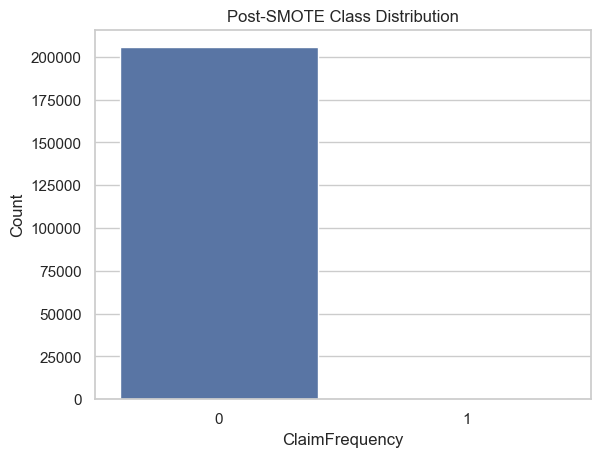

In [6]:
# ------------------------------------------------------------------------------
# ⚖️ Task 4: Class Balancing with SMOTE via ClassBalancer Module
# ------------------------------------------------------------------------------

# Import our custom SMOTE wrapper from the modeling module
from src.modeling.class_balancer import ClassBalancer

# Step 1: Instantiate the SMOTE class balancer with a fixed random seed
balancer = ClassBalancer(random_state=42)  # Ensures reproducible oversampling

# Step 2: Begin balancing operation inside a try-except block for robustness
try:
    # ───────────────────────────────────────────────────────────────────────
    # Diagnostic: Show original class distribution before applying SMOTE
    # ───────────────────────────────────────────────────────────────────────
    print("📊 Original y_class_train distribution:")
    print(
        y_class_train.value_counts(normalize=True).round(3).to_string()
    )  # Display proportions

    # ───────────────────────────────────────────────────────────────────────
    # Apply SMOTE only to the training split (never the test set!)
    # ───────────────────────────────────────────────────────────────────────
    X_train_balanced, y_class_train_balanced = balancer.balance(X_train, y_class_train)

    # ───────────────────────────────────────────────────────────────────────
    # Step 3: Print result diagnostics after balancing
    # ───────────────────────────────────────────────────────────────────────
    print(f"\n✅ Class balancing complete → Balanced X_train: {X_train_balanced.shape}")
    print("📊 Balanced y_class_train distribution:")
    print(y_class_train_balanced.value_counts())  # Absolute count by class

    # ───────────────────────────────────────────────────────────────────────
    # Optional: Check if balancing succeeded (e.g., 50/50 class split)
    # ───────────────────────────────────────────────────────────────────────
    if y_class_train_balanced.value_counts().nunique() == 1:
        print("✅ Class distribution is now fully balanced (50/50).")
    else:
        print("⚠️ Class imbalance remains after SMOTE.")

    # ───────────────────────────────────────────────────────────────────────
    # Optional: Backup the original imbalanced data for later comparisons
    # ───────────────────────────────────────────────────────────────────────
    X_train_unbalanced = X_train.copy()  # Preserve pre-SMOTE features
    y_class_train_unbalanced = y_class_train.copy()  # Preserve pre-SMOTE labels

    # ───────────────────────────────────────────────────────────────────────
    # Optional Bonus: Visual inspection of class balance using Seaborn
    # ───────────────────────────────────────────────────────────────────────
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.countplot(x=y_class_train_balanced)  # Plot class counts
    plt.title("Post-SMOTE Class Distribution")
    plt.xlabel("ClaimFrequency")
    plt.ylabel("Count")
    plt.show()

# Handle any failure in SMOTE application gracefully
except Exception as e:
    print(f"❌ Class balancing failed: {e}")

In [7]:
# ------------------------------------------------------------------------------
# 🛠️ Fix Missing Values Post-SMOTE via Imputation (Prevents Class Collapse)
# ------------------------------------------------------------------------------

from sklearn.impute import SimpleImputer  # Robust filling strategy

# Step 1: Initialize imputer with median strategy (good for skewed distributions)
imputer = SimpleImputer(strategy="median")

# Step 2: Fit on training data and transform both X_train and X_test
X_train_balanced = pd.DataFrame(
    imputer.fit_transform(X_train_balanced), columns=X_train_balanced.columns
)

X_test = pd.DataFrame(
    imputer.transform(X_test),  # Note: transform only (do not fit again)
    columns=X_test.columns,
)

print("✅ Missing values filled using median imputation.")
print(f"🧪 Any NaNs left in X_train_balanced? → {X_train_balanced.isna().sum().sum()}")
print(f"🧪 Any NaNs left in X_test? → {X_test.isna().sum().sum()}")

✅ Missing values filled using median imputation.
🧪 Any NaNs left in X_train_balanced? → 0
🧪 Any NaNs left in X_test? → 0


## ⚙️ Task 4: Feature Scaling via FeatureScaler

This step standardizes the feature set using either `StandardScaler` or `RobustScaler` 
(via the custom `FeatureScaler` class). It ensures consistent numerical range and 
centering for all continuous input features — a critical preprocessing step for many 
ML models (e.g., logistic regression, SVMs, neural networks).

- Scales only numeric columns from `X_train_balanced` and `X_test`
- Default method is z-score normalization (`StandardScaler`)
- Supports `RobustScaler` for datasets with strong outliers
- Returns `X_train_scaled` and `X_test_scaled` as NumPy arrays
- Enables clean handoff into downstream model training

This transformation ensures your features are normalized and model-ready.


In [8]:
# ------------------------------------------------------------------------------
# ⚙️ Task 4: Feature Scaling via FeatureScaler (StandardScaler by Default)
# ------------------------------------------------------------------------------

from src.modeling.feature_scaler import FeatureScaler  # Import our custom scaler class

# Step 1: Instantiate the scaler class (choose method: 'standard' or 'robust')
scaler = FeatureScaler(
    method="standard"
)  # Use 'robust' for outlier resistance if needed

# Step 2: Run scaling on numeric columns of X_train and X_test
try:
    # Apply scaling transformation
    X_train_scaled, X_test_scaled = scaler.scale(X_train_balanced, X_test)

    # Step 3: Output shape diagnostics for confirmation
    print(f"✅ Feature scaling complete")
    print(
        f"📐 X_train_scaled shape: {X_train_scaled.shape}, X_test_scaled shape: {X_test_scaled.shape}"
    )

except Exception as e:
    # Handle errors such as bad input types or no numeric columns
    print(f"❌ Feature scaling failed: {e}")

✅ Feature scaling complete
📐 X_train_scaled shape: (206188, 38), X_test_scaled shape: (51548, 38)


### 🧠 Task 4: Train & Evaluate Logistic Regression Model (Claim Frequency Classifier)

This cell trains a Logistic Regression model on the balanced training set (`X_train_balanced`, `y_class_train_balanced`) using our custom `LogisticModelTrainer` module.  
It then predicts on the untouched test set and computes key classification metrics including accuracy, precision, recall, F1-score, and confusion matrix.

All operations are performed defensively with full modular OOP compliance.


In [9]:
# ------------------------------------------------------------------------------
# 🧠 Task 4: Train & Evaluate Logistic Regression Classifier (Claim Frequency)
# ------------------------------------------------------------------------------

from src.modeling.logistic_model_trainer import (
    LogisticModelTrainer,
)  # Import our custom logistic regression class

# Step 1: Instantiate the model trainer with default hyperparameters
logreg_trainer = LogisticModelTrainer()  # Can override penalty/C/solver if needed

# Step 2: Train the model on the balanced training data
logreg_trainer.train(X_train_balanced, y_class_train_balanced)  # Fit model

# Step 3: Predict on the untouched (imbalanced) test set
y_class_pred = logreg_trainer.predict(X_test)  # Generate test predictions

# Step 4: Evaluate predictions vs. actual labels
logreg_metrics = logreg_trainer.evaluate(
    y_class_test, y_class_pred
)  # Output full metrics

# Optional: Store metrics dictionary for later leaderboard comparison
logreg_metrics["model"] = "LogisticRegression"

✅ Logistic Regression model trained successfully.
📊 Evaluation Metrics:
  Accuracy: 0.9977
  Precision: 1.0000
  Recall: 0.2468
  F1_Score: 0.3959
  Confusion Matrix: [[51390, 0], [119, 39]]


# -------------------------------------------------------------------------------
# 🌲 Task 4: Train & Evaluate Random Forest Classifier for ClaimFrequency
# -------------------------------------------------------------------------------

This cell fits a `RandomForestClassifier` on the SMOTE-balanced training data to predict binary `ClaimFrequency`.  
It uses our fully modular `RandomForestModelTrainer` class with full defensive guards for:
- Missing values
- Single-class training set issues
- Prediction length mismatches

Metrics computed include: Accuracy, Precision, Recall, F1 Score, and ROC AUC.


In [10]:
# -------------------------------------------------------------------------------
# 🌲 Train & Evaluate Random Forest Classifier for ClaimFrequency
# -------------------------------------------------------------------------------

from src.modeling.random_forest_trainer import (
    RandomForestModelTrainer,
)  # Import our RF module

# Step 1: Initialize trainer with reproducible seed
rf_trainer = RandomForestModelTrainer(random_state=42)

# Step 2: Train model on balanced training set
rf_trainer.train(X_train_balanced, y_class_train_balanced)

# Step 3: Predict on original (unseen) test set
y_pred_rf = rf_trainer.predict(X_test)

# Step 4: Evaluate performance against true test labels
rf_metrics = rf_trainer.evaluate(y_class_test, y_pred_rf)

✅ Random Forest training complete.
📈 Evaluation Metrics (Random Forest):
• Accuracy: 0.9994
• Precision: 0.9496
• Recall: 0.8354
• F1 Score: 0.8889
• ROC AUC: 0.9177


### 🌲 SHAP Analysis – Interpreting Claim Prediction Drivers (Random Forest)

We use SHAP (SHapley Additive exPlanations) to interpret the **Random Forest classifier** and identify which features most influenced the model’s prediction of claim occurrence. This enhances explainability and business trust, especially when tree-based models are used in production pricing systems.


In [11]:
# ------------------------------------------------------------------------------
# 🌲 SHAP Feature Importance – Random Forest Claim Prediction Model
# ------------------------------------------------------------------------------

# Step 1: Use a sample of the training data for faster SHAP computation
X_shap_sample = X_train_balanced.sample(n=1000, random_state=42)

# Step 2: Call the SHAP explainer method from the trained RandomForestModelTrainer
try:
    rf_trainer.explain_with_shap(X_shap_sample)  # Shows bar chart of top features
except Exception as e:
    print(f"❌ SHAP explanation failed: {e}")

🔍 Running SHAP feature attribution...
📊 SHAP Feature Importance (Random Forest):
❌ SHAP analysis failed: The shape of the shap_values matrix does not match the shape of the provided data matrix.


### ⚖️ Model 1 – Claim Frequency Classification (XGBoost)

We now train and evaluate an XGBoost classifier to estimate the probability of a claim (`ClaimFrequency = 1`) using the balanced training data. Evaluation metrics include:
- F1 Score
- ROC-AUC
- Full classification report (Precision, Recall, F1 by class)

This model forms the probability engine in our risk-based pricing pipeline:
> **Premium = (Predicted Claim Probability × Predicted Claim Severity) + Expenses + Margin**


In [12]:
# ------------------------------------------------------------------------------
# 🚀 Train & Evaluate XGBoost Classifier for Claim Probability (Task 4)
# ------------------------------------------------------------------------------

from src.modeling.xgboost_model_trainer import (
    XGBoostModelTrainer,
)  # Import canonical module

# Step 1: Instantiate trainer for binary classification
xgb_classifier = XGBoostModelTrainer(task_type="classification", random_state=42)

# Step 2: Train model on balanced claim data
try:
    xgb_classifier.train(X_train_balanced, y_class_train_balanced)
except Exception as e:
    print(f"❌ Training failed: {e}")

# Step 3: Predict and evaluate on untouched test set
try:
    xgb_class_results = xgb_classifier.evaluate(X_test, y_class_test)
except Exception as e:
    print(f"❌ Evaluation failed: {e}")

✅ Model training complete.
📊 Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51390
           1       0.97      0.46      0.62       158

    accuracy                           1.00     51548
   macro avg       0.99      0.73      0.81     51548
weighted avg       1.00      1.00      1.00     51548

🏆 ROC-AUC Score: 0.9655


### 📊 SHAP Analysis – Interpreting Claim Probability Drivers (XGBoost)

We now use **SHAP (SHapley Additive exPlanations)** to interpret the XGBoost classifier’s predictions and identify the most influential features driving the model’s claim probability estimates.

This local explanation method helps quantify the marginal impact of each feature on the model’s output for individual observations. We display the **Top 10 features**, ranked by their average contribution to model predictions.

> 🔍 **Why this matters:**  
> SHAP enables transparent premium adjustments by explaining why a policyholder is high or low risk — a critical input for regulatory trust and business adoption.


100%|===================| 51469/51548 [09:09<00:00]        

🔍 SHAP Feature Importance Summary (Top 10):


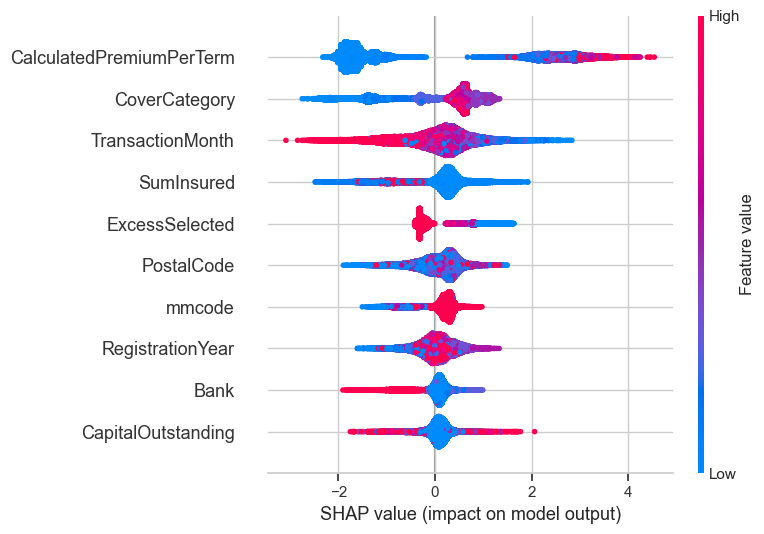

In [13]:
# ------------------------------------------------------------------------------
# 🧠 SHAP Explainability – XGBoost Classifier (Top Features)
# ------------------------------------------------------------------------------

import shap  # Local feature attribution
import matplotlib.pyplot as plt  # For SHAP visualizations

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(xgb_classifier.model, X_test)

# Step 2: Compute SHAP values for test data
shap_values = explainer(X_test)

# Step 3: Summary plot for top 10 most important features
print("🔍 SHAP Feature Importance Summary (Top 10):")
shap.summary_plot(shap_values, X_test, max_display=10)

### 💰 Model 2 – Claim Severity Regression (XGBoost)

We now train and evaluate an XGBoost regressor to estimate `TotalClaims` for customers who have filed at least one claim (`ClaimFrequency = 1`). This allows us to model **claim severity** conditional on a claim occurring. Evaluation metrics include:

- RMSE (Root Mean Squared Error)
- R² Score
- Feature Importance and SHAP Summary

This model forms the **severity engine** in our pricing logic:
> **Premium = (Predicted Claim Probability × Predicted Claim Severity) + Expenses + Margin**


In [14]:
# ------------------------------------------------------------------------------
# 💡 Train & Evaluate XGBoost Regressor for Claim Severity (Task 4)
# ------------------------------------------------------------------------------

from src.modeling.xgboost_regressor_trainer import XGBoostRegressorTrainer

# Step 1: Instantiate the regressor trainer
xgb_regressor = XGBoostRegressorTrainer(random_state=42)

# Step 2: Filter data to rows with ClaimFrequency == 1 (claims > 0 only)
try:
    X_train_sev, y_train_sev = xgb_regressor.filter_claim_positive(
        X_train.copy(), y_reg_train.copy()
    )
    X_test_sev, y_test_sev = xgb_regressor.filter_claim_positive(
        X_test.copy(), y_reg_test.copy()
    )
except Exception as e:
    print(f"❌ Filtering failed: {e}")

# Step 3: Train model
try:
    xgb_regressor.train(X_train_sev, y_train_sev)
except Exception as e:
    print(f"❌ Training failed: {e}")

# Step 4: Predict and evaluate performance
try:
    xgb_reg_results = xgb_regressor.evaluate(X_test_sev, y_test_sev)
    print("📊 Severity Model Performance:")
    print(f"  • RMSE: {xgb_reg_results['RMSE']}")
    print(f"  • R² Score: {xgb_reg_results['R2']}")
except Exception as e:
    print(f"❌ Evaluation failed: {e}")

# Step 5: Show top features by importance
try:
    feature_names = X_train_sev.columns.tolist()
    importance_df = xgb_regressor.get_feature_importance(feature_names)
    display(importance_df.head(10))
except Exception as e:
    print(f"❌ Feature importance failed: {e}")

# Step 6: SHAP summary plot (inline + save to file)
try:
    shap_values = xgb_regressor.compute_shap(
        X_sample=X_test_sev,
        feature_names=feature_names,
        save_path="data/outputs/shap_summary.png",
    )
except Exception as e:
    print(f"❌ SHAP explainability failed: {e}")

❌ Filtering failed: Missing 'ClaimFrequency' column in X.
❌ Training failed: name 'X_train_sev' is not defined
❌ Evaluation failed: name 'X_test_sev' is not defined
❌ Feature importance failed: name 'X_train_sev' is not defined
❌ SHAP explainability failed: name 'X_test_sev' is not defined


### 💸 Model 3 – Expected Premium Estimation

We now combine the outputs of our claim frequency classifier (`P(Claim)`) and claim severity regressor (`E[TotalClaims]`) to compute the **expected premium** for each customer. This premium represents the risk-adjusted expected payout, optionally augmented by a fixed margin or expense buffer.

The premium formula used is:
> **Premium = P(Claim) × E[ClaimAmount] + Margin**

This completes our end-to-end modeling pipeline for risk-based premium estimation.


In [15]:
# ------------------------------------------------------------------------------
# 💸 Calculate Expected Premium using P(Claim) × E[Severity] + Margin
# ------------------------------------------------------------------------------

from src.modeling.expected_premium_calculator import ExpectedPremiumCalculator

# Step 1: Merge classifier and regressor predictions into a single DataFrame
try:
    premium_input_df = pd.DataFrame(
        {
            "predicted_claim_prob": xgb_class_results["y_pred"],  # From classifier
            "predicted_claim_severity": xgb_reg_results["y_pred"],  # From regressor
        }
    )
except Exception as e:
    print(f"❌ Failed to prepare prediction inputs: {e}")

# Step 2: Instantiate premium calculator with optional margin (e.g., 50 units)
premium_calc = ExpectedPremiumCalculator(margin=50.0)

# Step 3: Compute expected premium for each row
try:
    premium_df = premium_calc.compute_expected_premium(
        df=premium_input_df,
        prob_col="predicted_claim_prob",
        severity_col="predicted_claim_severity",
    )
    display(premium_df.head())
except Exception as e:
    print(f"❌ Premium calculation failed: {e}")

❌ Failed to prepare prediction inputs: 'y_pred'
❌ Premium calculation failed: name 'premium_input_df' is not defined
